# Vehicle detection and tracking pipeline
## Explore the data set

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
from sklearn.utils import shuffle

%matplotlib inline

# Read in our vehicles and non-vehicles
cars = glob.glob('data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('data/non-vehicles/**/*.png', recursive=True)
print("{} car images".format(len(cars)))
print("{} non-car images".format(len(notcars)))

cars = shuffle(cars)
notcars = shuffle(notcars) 

8792 car images
8968 non-car images


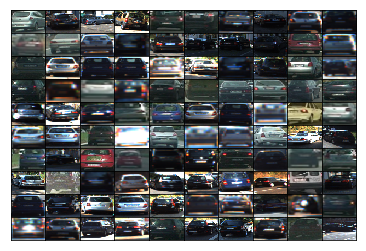

In [2]:
gs = gridspec.GridSpec(10, 10, top=.8, bottom=0., right=.8, left=0., hspace=0., wspace=0.)
for g in gs:
    ind = np.random.randint(0, len(cars))
    image = mpimg.imread(cars[ind])
    ax = plt.subplot(g)
    ax.imshow(image)
    ax.set_aspect('auto')
    ax.set_xticks([])
    ax.set_yticks([])

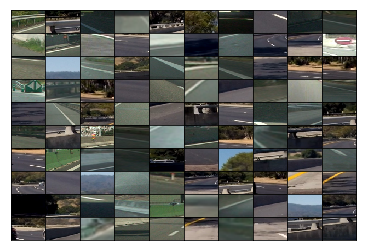

In [3]:
gs = gridspec.GridSpec(10, 10, top=.8, bottom=0., right=.8, left=0., hspace=0., wspace=0.)
for g in gs:
    ind = np.random.randint(0, len(notcars))
    image = mpimg.imread(notcars[ind])
    ax = plt.subplot(g)
    ax.imshow(image)
    ax.set_aspect('auto')
    ax.set_xticks([])
    ax.set_yticks([]) 

## Set hyper-parameters

In [4]:
# Hyper-parameters to tweak
color_space = 'HLS' # Can be HSV, LUV, HLS, YUV, YCrCb or None
orient = 9  # HOG orientations
pix_per_cell = 12 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
hist_bins = 230 # Number of histogram bins
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

## Extract HOG features

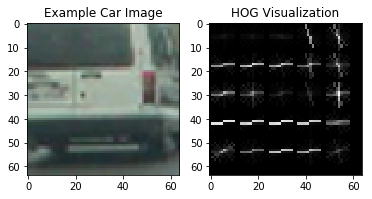

In [5]:
import cv2
from skimage.feature import hog


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, block_norm="L2-Hys",
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, block_norm="L2-Hys",
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Get a random car image from the data set
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


## Extract training features

In [6]:
from sklearn.preprocessing import StandardScaler
from utils import *

def extract_features(imgs, color_space=None,
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        img = mpimg.imread(file)
        feature_image = convert_rgb_image(img, color_space)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


car_features = extract_features(cars, color_space=color_space, 
                        hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(car_features[0]))

Using: 9 orientations 12 pixels per cell and 4 cells per block
Feature vector length: 2418


## Train the classifier
### Prepare train and test data sets

In [7]:
from sklearn.svm import LinearSVC, SVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

/Users/zhuchkov/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zhuchkov/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [8]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1000)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print("{} train items".format(len(X_train)))
print("{} test items".format(len(X_test)))

14208 train items
3552 test items


### Search for the best classifier parameters

In [9]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 100], 'gamma': [0.001, 100]}
clf = SVC()
gscv = GridSearchCV(clf, parameters)
gscv.fit(X_train[:2000], y_train[:2000])

print(gscv.best_score_, gscv.best_params_)

0.988 {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}


### Fit the calssifier and evaluate its score

In [10]:
# Use an SVC
svc = SVC(C=100, kernel='rbf', gamma=0.001)
svc.fit(X_train, y_train)

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

n_predict = 15
print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])

Test Accuracy of SVC =  0.9932
My SVC predicts:      [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.]
For these 15 labels:  [ 0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  1.]


### Plot an example of raw and scaled features

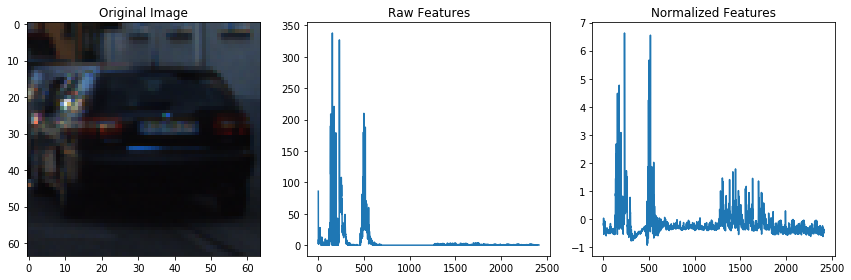

In [11]:
car_ind = np.random.randint(0, len(cars))
fig = plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## Search and detect vehicles

CPU times: user 2.59 s, sys: 12.3 ms, total: 2.6 s
Wall time: 2.61 s


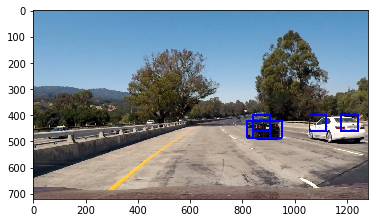

In [45]:
y_start_stop = [350, 600] # Min and max in y to search in slide_window()
scale = 1 # Sub-sampling scale factor

# Define a single function that can extract features using hog sub-sampling and make predictions
def search_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hist_bins):
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    feature_image = convert_rgb_image(img_tosearch, color_space)       
    
    if scale != 1:
        imshape = feature_image.shape
        feature_image = cv2.resize(feature_image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = feature_image[:,:,0]
    ch2 = feature_image[:,:,1]
    ch3 = feature_image[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the original sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    
    boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(feature_image[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append( ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)) )               
       
    return boxes


def draw_boxes(img, boxes):
    draw_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6) 
    return draw_img


image = mpimg.imread('test_images/test1.jpg')
%time boxes = search_cars(image, y_start_stop[0], y_start_stop[1], scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hist_bins)
plt.imshow(draw_boxes(image, boxes))

### Reduce false positives

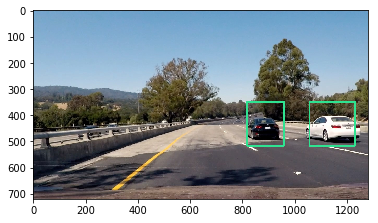

In [46]:
from scipy.ndimage.measurements import label
from skimage.filters import gaussian

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (47,227,145), 6)
    # Return the image
    return img


def get_labels(image, boxes, threshold=1):
    # Add heat to each box in box list
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap_res = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    return label(heatmap_res)    


def get_labels_mul(image, boxes_list, threshold=1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for boxes in boxes_list:
        heat = add_heat(heat, boxes) 
        
    heat = apply_threshold(heat, threshold)
    heatmap_res = np.clip(heat, 0, 255)

    return label(heatmap_res)        

def find_cars(image):
    boxes_1 = search_cars(image, y_start_stop[0], y_start_stop[1], 1.5, 
                          svc, X_scaler, color_space, 
                          orient, pix_per_cell, cell_per_block, hist_bins)
    boxes_2 = search_cars(image, y_start_stop[0], y_start_stop[1], 2, 
                          svc, X_scaler, color_space, 
                          orient, pix_per_cell, cell_per_block, hist_bins)    

    labels = get_labels(image, boxes_1 + boxes_2, 1)
    out_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return out_img
    
image = mpimg.imread('test_images/test4.jpg')
res_img = find_cars(image)
plt.imshow(res_img)

## Video processing

In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:
def find_frame_boxes(image):
    boxes_1 = search_cars(image, 380, 540, 1, 
                          svc, X_scaler, color_space, 
                          orient, pix_per_cell, cell_per_block, hist_bins)    
    boxes_2 = search_cars(image, 400, 600, 1.5, 
                          svc, X_scaler, color_space, 
                          orient, pix_per_cell, cell_per_block, hist_bins)
    boxes_3 = search_cars(image, 400, 600, 2, 
                          svc, X_scaler, color_space, 
                          orient, pix_per_cell, cell_per_block, hist_bins)

    return boxes_1 + boxes_2 + boxes_3

first_frame = True
boxes = []

def process_image(get_frame, t):
    global first_frame, boxes  
    
    if first_frame:
        first_frame = False
        for i in range(6):
            frame = get_frame(t+i/26)
            if frame is not None:
                boxes.append(find_frame_boxes(frame))
    else:
        del(boxes[0])       
        frame = get_frame(t+5/26)
        if frame is not None:
            boxes.append(find_frame_boxes(frame))
            
    image = get_frame(t)            
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for bb in boxes:
        heat = add_heat(heat, bb)    
    heatmap_res = np.clip(heat, 0, 255)
    
    '''plt.figure()
    plt.imshow(heatmap_res)'''    
    
    labels = get_labels_mul(image, boxes, 4)
    
    '''plt.figure()
    plt.imshow(labels[0])  '''   
    
    out_img = draw_labeled_bboxes(np.copy(image), labels)

    return out_img

In [54]:
video_output = 'video_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl(process_image)
%time clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4



 12%|█▏        | 152/1261 [06:28<48:18,  2.61s/it]


 24%|██▍       | 303/1261 [13:19<43:24,  2.72s/it]


 36%|███▌      | 454/1261 [20:09<36:14,  2.69s/it]


 48%|████▊     | 605/1261 [26:56<29:18,  2.68s/it]


 60%|█████▉    | 756/1261 [33:41<22:40,  2.69s/it]


 72%|███████▏  | 907/1261 [40:29<15:59,  2.71s/it]


 84%|████████▍ | 1057/1261 [47:14<09:12,  2.71s/it]


 96%|█████████▌| 1205/1261 [53:53<02:29,  2.66s/it]


100%|█████████▉| 1260/1261 [56:20<00:02,  2.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

CPU times: user 53min 4s, sys: 1min, total: 54min 4s
Wall time: 56min 21s


In [ ]:
HTML("""
<video width="768" height="432" controls>
  <source src="{0}">
</video>
""".format(video_output))